<a href="https://colab.research.google.com/github/amandascm/covid19classifier/blob/main/interpClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**An interpretable classifier for chest x-ray images**

This project aims to feed a deep learning model with a chest x-ray input and obtain a positive / negative forecast for COVID-19 plus a heat map that represents the regions of interest used to determine the obtained response.

It has 2 main modules:
- A Convolutional Neural Network developed from scratch
- A Grad-CAM technique implementation

These tools provide to the project the image classification ability (CNN) and the visual interpretability of the CNN predictions (Grad-CAM), which are extremely relevant to the social role that an auxiliary diagnostic tool fulfills.

In addition, our deep learning model was trained and tested with the [Kaggle dataset from CoronaHack](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset) (its preprocessment is also implemented and described bellow).


##**Imports and setup**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import os

SEED = 23
random.seed(SEED)

inputShape = (128,128,3)

##**Our Model**


---



####**Architecture:**
This model was inspired by the COVID-XNet architecture, a deep learning project developed to classifiy chest x-rays (Article: COVID-XNet: A Custom Deep Learning System to Diagnose and Locate COVID-19 in Chest X-ray Images).

The layers are:

**(Conv1) -> (MaxPool1) -> (Conv2) -> (MaxPool2) -> (Conv3) -> (MaxPool3) -> (Conv4) -> (MaxPool4) -> (Conv5) -> (MaxPool5) -> (GAP) -> (Sigmoid)**

####**Model definition**
- Layers
- Optimizer, loss and metrics

In [ ]:
class OurModel():
  def __init__(self, modelPath):
    self.modelPath = modelPath
    # Initializes a keras model to carry our Network
    self.model = keras.Sequential()
    # Layers
    self.addLayers()
    # Optimizer, loss and metrics
    self.configureCompile()
    # Callbacks
    self.defineCallbacks()

  def configureCompile(self):
    self.model.compile(optimizer='adam',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])
    
  def defineCallbacks(self):
    # Checkpoint to ensure our model gets saved everytime it reaches a better accuracy value
    checkpoint = keras.callbacks.ModelCheckpoint(filepath=f'{self.modelPath}', 
                  monitor='val_accuracy', verbose=0,
                  save_best_only=True, mode='max')
    self.callbacks = [checkpoint]

  def addLayers(self):
    self.model.add(keras.Input(shape=inputShape, name="Input"))
    self.addConvMax(convFilters=14, convKernelSize=5, convActiv="relu", maxPoolSize=(2,2), i=1)
    self.addConvMax(convFilters=28, convKernelSize=5, convActiv="relu", maxPoolSize=(2,2), i=2)
    self.addConvMax(convFilters=28, convKernelSize=5, convActiv="relu", maxPoolSize=(2,2), i=3)
    self.addConvMax(convFilters=28, convKernelSize=3, convActiv="relu", maxPoolSize=(2,2), i=4)
    self.addConvMax(convFilters=56, convKernelSize=3, convActiv="relu", maxPoolSize=(2,2), i=5)
    self.addClassifier(1)

  # Function to add a Conv followed by a MaxPool layer in our model
  def addConvMax(self, convFilters, convKernelSize, convActiv, maxPoolSize, i):  
    self.model.add(keras.layers.Conv2D(filters=convFilters, kernel_size=convKernelSize, activation=convActiv, name=f'Conv{i}'))
    self.model.add(keras.layers.MaxPool2D(pool_size=maxPoolSize, name=f'MaxPool{i}'))

  # Function to add a GAP followed by a dense (sigmoid) layer
  def addClassifier(self, i):  
    self.model.add(keras.layers.GlobalAvgPool2D(name=f'GAP{i}'))
    self.model.add(keras.layers.Dense(1, activation='sigmoid', name=f'Sigmoid{i}'))

In [ ]:
# Example
myCNN = OurModel("CNN0")
myCNN.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 124, 124, 14)      1064      
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 62, 62, 14)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 58, 58, 28)        9828      
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 29, 29, 28)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 25, 25, 28)        19628     
_________________________________________________________________
MaxPool3 (MaxPooling2D)      (None, 12, 12, 28)        0         
_________________________________________________________________
Conv4 (Conv2D)               (None, 10, 10, 28)        7

##**Getting our dataset**


---



We will import a Kaggle dataset from the CoronaHack - Chest X-Ray-Dataset. To do so, you need to:
- Have a Kaggle account
- Go to Account -> Account -> Create new API token -> download your kaggle.json file
- Open your google drive, create a new folder named 'Kaggle' in your root directory (My drive) and upload your kaggle.json inside it
- Run the following cells

###**Import dataset**

####**Mount our drive folders**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


####**Configure environment**

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

####**Download data**

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

coronahack-chest-xraydataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
%cd ../../..

/content


###**Unzip**

In [ ]:
!unzip /content/gdrive/MyDrive/Kaggle/coronahack-chest-xraydataset.zip -d ./dataset

###**Dataset variables**
- metadata file (contains information about our images)
- train directory path
- test directory path
- datasets path

In [ ]:
METADATA_PATH = '/content/dataset/Chest_xray_Corona_Metadata.csv'
TRAIN_DIR_PATH = '/content/dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'
TEST_DIR_PATH = '/content/dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'
SETS_DIR_PATH = '/content/dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/'

##**Dataset preprocessing**


---



Let's check how are our x-ray images described in our metadata file:

In [ ]:
# Put our metadata in a dataframe
metadata = pd.read_csv(METADATA_PATH)

In [ ]:
# Print the first 5 rows of our dataframe
metadata.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


###**About our metadata**

In order to correctly use our available data, we must select the needed information to our goal: classify an x-ray image as a COVID-19 or non-COVID-19 case. Initially, we have all these informations about our x-ray images:

| Columns   |      Meaning      |
|----------|:-------------:|
| **X_ray_image_name** |  jpeg file name |
| **Label** |  'Normal' or 'Pnemonia' |
| **Dataset_type** |  If image belongs to 'TRAIN' or 'TEST' set |
| **Label_1_Virus_category** |  Presence of virus, bacteria or smoking stress ('bacteria', 'Virus' or 'Stress-Smoking') |
| **Label_2_Virus_category** |  If Label_1_Virus_category has value equals to 'Virus', indicates the present virus ('COVID-19', 'SARS'...)|

To classify our inputs as COVID-19 or non-COVID-19 cases we will need **X_ray_image_name**, **Label**, **Dataset_type** and **Label_2_Virus_category** columns of our dataframe.

In [ ]:
# Discard unnecessary columns
metadata.drop(['Unnamed: 0', 'Label_1_Virus_category'], inplace=True, axis=1)

###**Current dataframe:**

In [ ]:
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN


###**Remaking our labels and adding new columns**

As we only need to know if we have a COVID-19 case or a non-COVID-19 case we can reassign the following labels to our x-ray samples and create a column designed to classifiy them into 'negative' or 'positive' class:

| Label   |      Value      |
|----------|:-------------:|
| **positive** |  1 |
| **negative** |  0 |

In [ ]:
negClassLabel = 'negative'
posClassLabel = 'positive'
negClassValue = 0
posClassValue = 1

###**Split the dataframe into two**



####**Negative class dataframe:**

In [ ]:
# Dataframe with all non-COVID samples data
nonCovid = metadata[metadata['Label_2_Virus_category'] != 'COVID-19']
nonCovid['Value'] = negClassValue
nonCovid['Label'] = negClassLabel
nonCovid.drop(columns=['Label_2_Virus_category'], inplace=True)

In [ ]:
nonCovid.head()

,X_ray_image_name,Label,Dataset_type,Value
0,IM-0128-0001.jpeg,negative,TRAIN,0
1,IM-0127-0001.jpeg,negative,TRAIN,0
2,IM-0125-0001.jpeg,negative,TRAIN,0
3,IM-0122-0001.jpeg,negative,TRAIN,0
4,IM-0119-0001.jpeg,negative,TRAIN,0


####**Positive class dataframe:**

In [ ]:
# Dataframe with all COVID samples data
covid = metadata[metadata['Label_2_Virus_category'] == 'COVID-19']
covid['Value'] = posClassValue
covid['Label'] = posClassLabel
covid.drop(columns=['Label_2_Virus_category'], inplace=True)

In [ ]:
covid.head()

,X_ray_image_name,Label,Dataset_type,Value
5221,kjr-21-e25-g001-l-a.jpg,positive,TRAIN,1
5222,kjr-21-e24-g003-l-a.jpg,positive,TRAIN,1
5223,kjr-21-e24-g002-l-a.jpg,positive,TRAIN,1
5224,kjr-21-e24-g001-l-a.jpg,positive,TRAIN,1
5225,jkms-35-e79-g001-l-c.jpg,positive,TRAIN,1


####**Dataframes shapes:**

In [ ]:
print(f'Shape of non-COVID dataframe: {nonCovid.shape}')
print(f'Shape of COVID dataframe: {covid.shape}')

Shape of non-COVID dataframe: (5852, 4)
Shape of COVID dataframe: (58, 4)


###**Balance data**
As we have seen until this point, we have 58 samples representing one of our classes, and almost 100 times more than this representing the other class. This situation gives us an imbalanced dataset, which can cause a biased classification. To solve this sort of problem, we can try a process of **data augmentation** for our positive class along with an **undersampling** process for our majoritary class.

Firstly, let's gather our classes images together based on our dataframes information. In order to store our images in memory, we will create some arrays:
- **covidImages:** to store our COVID images as normalized arrays (easier to feed deep learning models or to preprocess them)
- **nonCovidImages:** to store our non-COVID images as normalized arrays (easier to feed deep learning models or to preprocess them)
- **newImages:** to store the COVID images variations (generated after data augmentation)


In [ ]:
# Function to put images described by one of our dataframes inside a list
def gatherImages(arr, dataframe):
  for i in range(0, len(dataframe)):
    row = dataframe.iloc[i, :]
    if row['Dataset_type'] == 'TRAIN':
      imagePath = f"{TRAIN_DIR_PATH}{row['X_ray_image_name']}"
    else:
      imagePath = f"{TEST_DIR_PATH}{row['X_ray_image_name']}"
    # Load image
    img = load_img(imagePath)
    # Resize image
    img = img.resize(inputShape[:2])
    # Image to array
    img = img_to_array(img)
    # Make a numpy array with our image
    img = np.array(img)
    arr += [img]

In [ ]:
covidImages = []
gatherImages(arr=covidImages, dataframe=covid)

In [ ]:
nonCovidImages = []
gatherImages(arr=nonCovidImages, dataframe=nonCovid)

####**Data augmentation**

Now let's instantiate an Image Generator to create variations of our COVID images (making horizontal flips, zooming etc):

In [ ]:
imgGen = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
)

We want to generate images, so we will make a folder named 'new' to store them (in the same directory where we have our 'train' and 'test' folders):

In [ ]:
# In case the folder has already been created
!rm -rf /content/dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/new

In [ ]:
# Directory creation
newPath = f"{SETS_DIR_PATH}new"
!mkdir {newPath}

Creating our ImageDataGenerator flow (allows us to generate X images if it is invoked X times) and saving our x-ray variations in the 'new' directory:

In [ ]:
# Function to invoke the dataGenerator 2 times per image
def augmentData(img, arr, seed):
  flowImgGen = imgGen.flow(np.array([img]), batch_size=1, save_to_dir=newPath, save_prefix='covid_', save_format='jpeg', seed=seed)
  qtNewImages = 2
  counter = 0
  for (i, newImage) in enumerate(flowImgGen):
    counter += 1
    newImage = array_to_img(newImage[0])
    newImage = img_to_array(newImage)
    # Make a numpy array with our image
    newImage = np.array(newImage)
    arr += [newImage]
      
    if counter == qtNewImages:
      break

In [ ]:
newCovidImages = []

for i in range(0, len(covidImages)):
  augmentData(covidImages[i], newCovidImages, seed=SEED+i)

#####**Saving our new images in the COVID-19 dataframe**

In [ ]:
for fileName in os.listdir(f'{SETS_DIR_PATH}new'):
  covid = covid.append({'X_ray_image_name': fileName, 'Label': posClassLabel, 'Dataset_type':'NEW', 'Value': posClassValue}, ignore_index=True)

In [ ]:
covid[covid['Dataset_type'] == 'NEW'].head()

,X_ray_image_name,Label,Dataset_type,Value
58,covid__0_5610.jpeg,positive,NEW,1
59,covid__0_7150.jpeg,positive,NEW,1
60,covid__0_87.jpeg,positive,NEW,1
61,covid__0_9070.jpeg,positive,NEW,1
62,covid__0_6617.jpeg,positive,NEW,1


#####**New images amount and shape:**

In [ ]:
print(f'Total of new images: {len(newCovidImages)}')
print(f'Shape of new images array: {np.array(newCovidImages).shape}')

Total of new images: 116
Shape of new images array: (116, 128, 128, 3)


#####**Current COVID images:** 

In [ ]:
finalCovid = covidImages + newCovidImages
finalCovidLabels = len(finalCovid)*[np.array([1])]
print(f'(amount of images, width, height, channels) = {np.array(finalCovid).shape}')

(amount of images, width, height, channels) = (174, 128, 128, 3)


####**Balancing our dataset**

Our situation is:
- We have 58 original covid images
- We have 116 variations of 58 covid images (new data)

Which gives us a total of 174 covid class samples. To reach a balanced dataset, we need the same amount of non-covid samples.
Let's select 174 random samples from it:

In [ ]:
random.seed(a=SEED, version=2) #ensures we'll reproduce the same random selection in every execution
finalNonCovid = (random.choices(np.array(nonCovidImages), k=len(finalCovid)))
finalNonCovidLabels = np.zeros((len(finalCovid),1))

**Final dataset array:**
- 174 COVID-19 x-rays
- 174 non-COVID-19 x-rays

In [ ]:
finalDataset = np.array(finalCovid+finalNonCovid)
finalLabels = np.array(list(finalCovidLabels) + list(finalNonCovidLabels))
print(f'Dataset shape: {finalDataset.shape}')

Dataset shape: (348, 128, 128, 3)


##**Training and results**

###**Validation technique: train and test sets**

To define our training and testing sets, we must choose a validation pattern to split our data and posteriorly evaluate our deep models performance.

Since we have little data, the **k-fold cross validation** technique seems to be a good choice to measure the average accuracy of our model: it varies the composition of the train and the test set k times. This technique can indicate the model generalization capability and point to a possible **overfitting** situation if the performance of each fold diverges too much from the others.

> "In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation." (From Wikipedia)



Let's make it real:

In [ ]:
nFolds = 5 # 4 will be used as train set, 1 will be used as test set
kFoldValidator = KFold(n_splits=nFolds, shuffle=True, random_state=SEED) # instance of K-fold validator
accPerFold = []
lossPerFold = []

###**Training**

####**Some hyperparameters**

In [ ]:
nEpochs = 50
batchSize = 4

####**Models directory**

To store our best-performing models

In [ ]:
MODEL_PATH_BASE = './models/'

In [ ]:
# In case the folder has already been created and you want to remove it
!rm -rf {MODEL_PATH_BASE}

In [ ]:
# Directory where deep models must be saved in
newPath = f"{MODEL_PATH_BASE}"
!mkdir {newPath}

####**Train and save models**

In [ ]:
results = pd.DataFrame(data=[], columns=["Fold", "Accuracy", "Loss"]) # Results of our k folds
sets = kFoldValidator.split(finalDataset, finalLabels) # sets from our finalDataset
modelPath = f"{MODEL_PATH_BASE}modelFold"

In [ ]:
fold = 1
for train, test in sets:
  # Model instance
  myModelClass = OurModel(f"{modelPath}{fold}")
  # Fit data (train and test)
  history = myModelClass.model.fit(finalDataset[train], finalLabels[train],
              batch_size=batchSize,
              epochs=nEpochs,
              verbose=0,
              callbacks=myModelClass.callbacks,
              validation_data=(finalDataset[test], finalLabels[test]),)
  # Scores
  scores = myModelClass.model.evaluate(finalDataset[test], finalLabels[test], verbose=0)
  # Results accumulator
  results = results.append({'Fold': fold, 'Accuracy': (scores[1] * 100), 'Loss': scores[0]}, ignore_index=True)
  fold += 1


###**Results**

####**Results per fold**

In [ ]:
results.head()

,Fold,Accuracy,Loss
0,1.0,98.571426,0.099505
1,2.0,95.714283,0.600167
2,3.0,95.714283,0.235827
3,4.0,97.101450,0.148596
4,5.0,95.652175,0.244975


####**Average results**

In [ ]:
pd.DataFrame([]).append({"Accuracy": results["Accuracy"].mean(), "Loss": results["Loss"].mean()}, ignore_index=True)

,Accuracy,Loss
0,96.550723,0.265814


####**Select the best performing model**

In [ ]:
foldIndex = results["Loss"].argmin()
foldIndex = results.iloc[foldIndex]["Fold"]
myModel = keras.models.load_model(f"{modelPath}{int(foldIndex)}")

####**Performance metrics**
There are some relevant performance metrics that tell us a little bit more about our model predictions. In this case, we care mainly about our precision because the bigger it is, the less positive misdiagnosis will be provided: we don't want to tell a doctor his patient has COVID-19 when he actually don't.

*   **Precision:** Division between true positives and predicted positives

$$\frac{True\ Positives}{(True\ Positives + False\ Positives)}$$

*   **Recall:** True positives from one class divided by the total of samples from the same class (true positives + false negatives)

$$\frac{True\ Positives}{(True\ Positives + False\ Negatives)}$$

*   **F1-score**: Harmonical mean between recall and precision

$$\frac{2}{\frac{1}{Precision} + \frac{1}{Recall}}$$

In [ ]:
pred = myModel.predict_classes(finalDataset[test])
print(classification_report(finalLabels[test], pred.flatten()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        39

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


####**Confusion Matrix**

In [ ]:
pd.DataFrame(np.array(confusion_matrix(finalLabels[test], pred)), columns=["negativePred", "positivePred"], index=["negative", "positive"])


,negativePred,positivePred
negative,30,0
positive,0,39


##**Grad-CAM**

It's an interpretative technique that helps understanding why a model predicted one of C classes with an image input. Grad-CAM generates a **class-discriminative localization map** and it doesn't require changes to be applied to many CNN models architecture (including ours)

###**Implementation**

In [ ]:
def getGradCAM(input, lastConvModel, classifierModel):
  # Gradient tape to provide gradients with respect to our lastConvOutput
  with tf.GradientTape() as tape:
      inputs = np.array([input])
      lastConvOutput = lastConvModel(inputs)
      tape.watch(lastConvOutput)
      preds = classifierModel(lastConvOutput)
      yClass = preds[0]

  # Gradients of our class score (yc) with relation to our last activation maps
  grads = tape.gradient(yClass, lastConvOutput)

  # GAP gradients (one value/pooledGrad per "channel")
  pooledGrads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # update shape to get only the 3 dimensions: HxWxC
  lastConvOutput = np.array(lastConvOutput)[0]
  pooledGrads = np.array(pooledGrads)
  # Multiply our pooledGrads by each correspondent activation map
  for i in range(pooledGrads.shape[0]):
      lastConvOutput[:, :, i] *= pooledGrads[i]

  # Sum all filters (result = 1 filter)
  gradcam = np.sum(lastConvOutput, axis=-1)
  # Apply ReLU to our result (with equivalent clip method) and normalize filter
  gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
  gradcam = cv2.resize(gradcam, inputShape[:2])
  return gradcam,preds[0]
  

##**Get your predictions**

If you have trained the model and ran the results cells in the **Train** session, you already have a model loaded in "myModel" object.

Otherwise, you can:
- upload a saved model as a zip file (and paste its path in the cell bellow)
- unzip it (run cell bellow)
- copy the path of the unzipped model, paste in the second cell bellow and run it

In [ ]:
zipModelPath = "/content/savedModel.zip" # make sure the zip file path is correct
!unzip {zipModelPath} -d ./
!rm -rf {zipModelPath}

Archive:  /content/savedModel.zip
   creating: ./savedModel/
  inflating: ./savedModel/saved_model.pb  
   creating: ./savedModel/variables/
  inflating: ./savedModel/variables/variables.index  
  inflating: ./savedModel/variables/variables.data-00000-of-00001  
   creating: ./savedModel/assets/


In [ ]:
myModel = keras.models.load_model("/content/savedModel") # make sure the model path is correct

###**Classification and Interpretability**

The goal of this project is to develop an auxiliary diagnostic tool which is capable of labeling an x-ray image input (classification ability), but also of providing a visual explanation (interpretability).
We achieve this with the combination of a CNN model with Grad-CAM technique. 

####**Prepare for Grad-CAM**
- We need the submodel of our main model until its last convolutional layer
- We need another submodel from the last conv. layer until the classifier one

In [ ]:
# Keras model from our first layer until the last convolutional one
lastConv = myModel.get_layer(name="Conv5")
lastConvModel = keras.Model(myModel.inputs, lastConv.output)
lastConvModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 124, 124, 14)      1064      
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 62, 62, 14)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 58, 58, 28)        9828      
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 29, 29, 28)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 25, 25, 28)        19628     
_________________________________________________________________
MaxPool3 (MaxPooling2D)      (None, 12, 12, 28)        0   

In [ ]:
# Keras model from our first layer after the lastConv until the output (classifier)
classifier = keras.models.Sequential()
# The last conv output is our classifier input
classifier.add(keras.Input(shape=lastConv.output.shape))
# Layers after the last conv layer to compose our classifier
for layerName in ["GAP1", "Sigmoid1"]:
  classifier.add(myModel.get_layer(name=layerName))
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GAP1 (GlobalAveragePooling2D multiple                  0         
_________________________________________________________________
Sigmoid1 (Dense)             multiple                  57        
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


####**Get and visualize predictions**
In this session we will:
- Select **k** random samples (and its labels) from our final dataset array
- Feed our model with each of the **k** samples and get as result a Grad-CAM map with the corresponding prediction (positive or negative)
- Plot the predicted classes, the true classes, the samples and their Grad-CAM maps

In [ ]:
# Test model with k random samples from our x-ray images
k = 3
random.seed(a=SEED, version=2)
idx = np.random.choice(np.arange(len(finalDataset)), k, replace=False)
samples = finalDataset[idx]
labels = finalLabels[idx]
gradcams = []
preds = []

# Get prediction and heat map for each sample
for img in samples:
  gradcam, pred = getGradCAM(input=img, lastConvModel=lastConvModel, classifierModel=classifier)
  preds += [posClassLabel if pred > 0.5 else negClassLabel]
  gradcams += [gradcam]

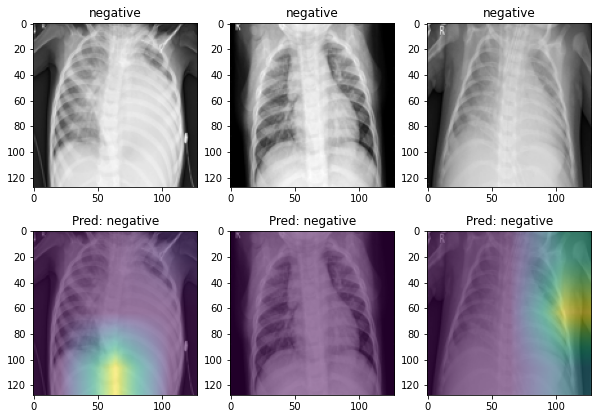

In [ ]:
# Plot
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = k
for i in range(k):
  fig.add_subplot(rows, columns, i+1)
  # showing image
  plt.title(posClassLabel if labels[i] else negClassLabel)
  plt.imshow(array_to_img(samples[i]))
  fig.add_subplot(rows, columns, k+i+1)
  # showing image
  plt.title(f"Pred: {preds[i]}")
  plt.imshow(array_to_img(samples[i]))
  plt.imshow(gradcams[i], alpha=0.5)

#####**Analysis**
Many of the heat maps obtained indicate regions of interest at the edges of the images, which may represent a bad generalization for the proposed problem. We can appeal to a trivial conclusion: lung diseases must be recognized in regions internal to the lungs. In this case, Grad-CAM also acts as an evaluator of our model and allows us to continue improving our project. 